# Cut descriptions in SHOP

The model setup for the two cut description examples are available in the following formats.

- pyshop
    - [cuts.py](#cuts.py)
    - [rhs_file.txt](#rhs_file.txt)
    - [wv_file.txt](#wv_file.txt)
- YAML
    - [model.yaml](#model.yaml)
    - [standard_cuts.yaml](#standard_cuts.yaml)
    - [price_dep_cuts.yaml](#price_dep_cuts.yaml)
- ASCII
    - [model.ascii](#model.ascii)
    - [name_coupling.txt](#name_coupling.txt)
    - [cut_order.txt](#cut_order.txt)
    - [standard_cuts.txt](#standard_cuts.txt)    
    - [price_dep_cuts.txt](#price_dep_cuts.txt)        

## Standard cut description
Adding a standard cut description to a simple two-reservoir system is show in this example. The cuts used in the example were generated by the prototype cut creation functionality in SHOP, and is therefore not saved to the standard text file format used by ProdRisk and Vansimtap.

In [1]:
#Necessary imports used in all examples
import pandas as pd
import cufflinks as cf
import plotly.offline as py
import plotly.graph_objs as go
cf.go_offline()
py.offline.init_notebook_mode(connected=True)
from pyshop import ShopSession

#Functions used in this example for building and solving a simple model with cuts
from cuts import build_model, run_model, read_cuts, get_minimal_cut_surface

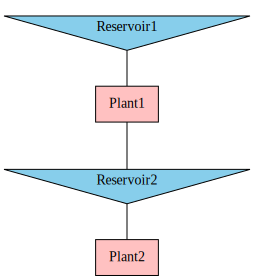

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a simple model with two reservoirs and two plants.
build_model(shop)
#Display topology to the screen
display(shop.model.build_connection_tree())

After the topology has been created, we read in the cuts from the text files. A new **cut_group** object must be created to hold the right-hand side constants of the cut constraints in the **rhs** attribute. The **water_value_input** attribute on the reservoir objects are used to store the cut coefficients with corresponding reference volumes. All reservoirs that are part of the cut constraints must be connected to the cut_group.

In [3]:
#Read the cut info
rhs_in,cut_coeffs = read_cuts()
n_cuts = len(rhs_in)

#Create a cut group object and add the RHS
my_cuts = shop.model.cut_group.add_object("my_cuts")
my_cuts.rhs.set([pd.Series(rhs_in, index=[0]*n_cuts, name=0)])

#Add the cut coefficients to the reservoirs and connect them to the cut_group
for rsv in shop.model.reservoir:
    name = rsv.get_name()
    
    v_ref = cut_coeffs[name][0]
    wv = cut_coeffs[name][1]
    
    rsv.water_value_input.set([pd.Series(wv, index=v_ref, name=0)])
    rsv.connect_to(my_cuts)    

The inequality constraints defined by each cut $k$ is

$c \leq \sum_i WV_{ik}\cdot(v_i - V_i^{ref}) + rhs_k \qquad \forall k,$

when formulated as profit maximization. The single cut variable $c$ is bounded from above by all the cuts, and the optimization problem tries to maximize its value. The cut coefficients $WV_{ik}$ for reservoir $i$ is multiplied with the end volume variable $v_i$ subtracted the cut reference volume. When all $v_i = V_i^{ref}$, the cut is bounded by the right hand side value $rhs_k$.

The cut constraints can be visualized as a 3D plot since there are only two reservoirs in this example. The x and y axis correspond to the end volume of each reservoir, while the z axis shows the cut value in terms of future expected income. Each cut is a plane in 3D which is spanned around a reference point with the reference volumes as x and y coordinates and the rhs as the z value. These points are plotted in 3D scatter plot below. The minimal surface spanned by all these cuts are also plotted, which is the effective bound that the optimization problem will see. The surface is found by taking the lowest (most restrictive) cut value over the set of cuts for different values of the reservoir volumes. 

Note that the reference points in red are marked as "never binding" and hover above the calculated minimal surface. This should not happen, as a cut should at least be binding exactly at the reference point. Non-convexities in the optimization program used to create these sample cuts are to blame in this case, as the SHOP cut creation functionality is still experimental. Some of the bidning cuts are also not binding at the reference point but somewhere else in the domain, which is also inaccurate.

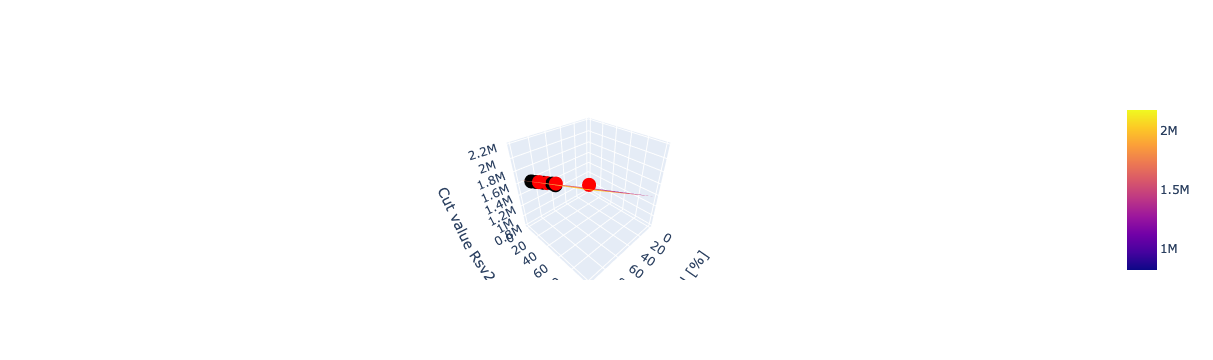

In [4]:
import numpy as np
rsv1 = shop.model.reservoir.Reservoir1
rsv2 = shop.model.reservoir.Reservoir2

vmax1 = rsv1.max_vol.get()
vmax2 = rsv2.max_vol.get()

v_ref1 = np.array(cut_coeffs["Reservoir1"][0])
v_ref2 = np.array(cut_coeffs["Reservoir2"][0])

v1 = np.arange(0,vmax1,0.25)
v2 = np.arange(0,vmax2,0.25)

#Add the reference volumes to the volume ranges to have a good representation for the surface around the reference points
v1 = np.concatenate((v1,v_ref1))
v1.sort()
v2 = np.concatenate((v2,v_ref2))
v2.sort() 

#Calculate the minimal cut surface and the binding cuts
binding_cuts, minimal_surface = get_minimal_cut_surface(rhs_in,cut_coeffs,v1,v2)

#Plot the cut surface
fig = go.Figure()
fig.add_trace(go.Surface(z=minimal_surface, x=v1*100/vmax1, y=v2*100/vmax2,hoverinfo="skip"))

colors = ["red"]*n_cuts
text = [f"Cut {i+1}, never binding" for i in range(n_cuts)]
for k in binding_cuts:
    colors[k] = "black"
    text[k] = f"Cut {k+1}, binding"
    
#Plot the reference points
fig.add_trace(go.Scatter3d(z=rhs_in, x=v_ref1*100/vmax1, y=v_ref2*100/vmax2,mode='markers',marker_color=colors,hovertext=text))

fig.update_scenes(
    aspectratio=dict(x=1, y=1, z=1),
    xaxis_title='Rsv1 vol [%]',
    yaxis_title='Rsv2 vol [%]',
    zaxis_title='Cut value'
)

fig.show()

Now we can run the optimization and look at the results. The final value in the TXY attribute **end_value** on the cut_group object holds the optimized cut value (future expected (negative) income). The **binding_cut_up** attribute holds the cut constraint that was the most constraining cut in this optimization.

In [5]:
#Optimize model by calling "run_model"
run_model(shop)

#Get the final end value of the cut group, which is the future expected (negative) profit
cut_val = -my_cuts.end_value.get()[-1]

#Get the binding cut constraint and print the cut information
cut_index = my_cuts.binding_cut_up.get()[-1]
cut_index = int(cut_index)

rhs_out = my_cuts.rhs.get()[0]
active_rhs = rhs_out.values[cut_index]

print(f"The future expeced income is {cut_val:.2f} € and the binding cut is number {cut_index+1} out of {n_cuts} with the following values:")
print(f"RHS is {active_rhs:.2f} €")
for rsv in shop.model.reservoir:
    name = rsv.get_name()
    
    cut_coeffs = rsv.water_value_input.get()[0]
    v_ref = cut_coeffs.index[cut_index]
    wv = cut_coeffs.values[cut_index]

    end_vol = rsv.storage.get()[-1]

    print(f"Cut coefficient {wv:.2f} €/Mm3 and refernve volume {v_ref:.2f} Mm3 for {name} with end volume {end_vol:.2f} Mm3")


The future expeced income is 1714041.83 € and the binding cut is number 8 out of 9 with the following values:
RHS is 1591330.63 €
Cut coefficient 20069.49 €/Mm3 and refernve volume 33.33 Mm3 for Reservoir1 with end volume 32.20 Mm3
Cut coefficient 5270.82 €/Mm3 and refernve volume 6.81 Mm3 for Reservoir2 with end volume 34.41 Mm3


Note that the attribute **binding_cut_down** is not used when the cuts are not price dependent, and have the default value of:

In [6]:
i = my_cuts.binding_cut_down.get()[-1]
print(f"'binding_cut_down' attribute for standard cuts: {i}")

'binding_cut_down' attribute for standard cuts: -1.0


The evolution of the reservoir storage and the global water value result time series are shown in the figures below. The final value of the global water value time series is equal to the binding cut coefficient for each reservoir.

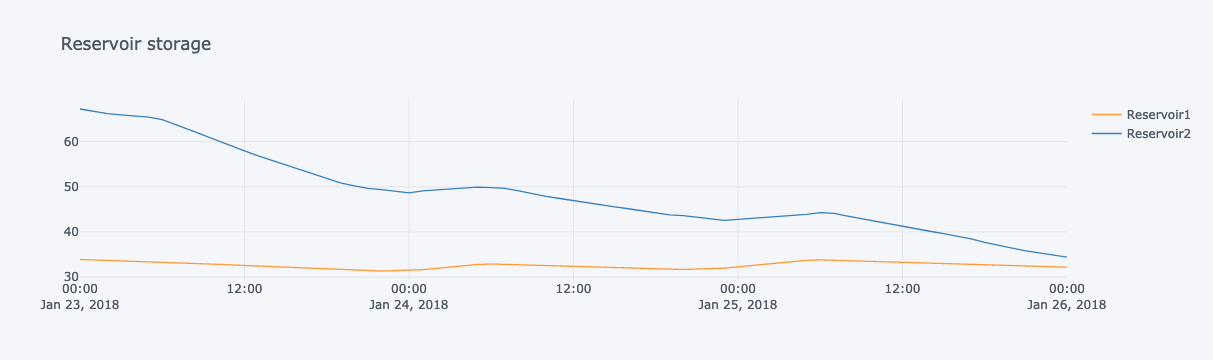

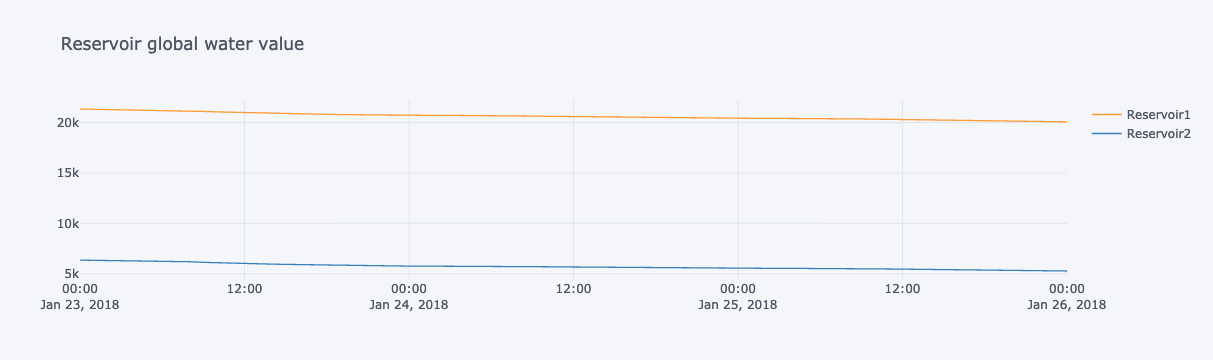

In [7]:
pd.DataFrame([rsv.storage.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir storage")
pd.DataFrame([-rsv.water_value_global_result.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir global water value")

# Price dependent cut description
To illustrate how price dependent cuts can be added to SHOP, we will use the same cuts as in the example above and synthesize some price variations. 

In [8]:
import numpy as np

#Create a standard ShopSession
shop=ShopSession()
#Build a simple model with two reservoirs and two plants.
build_model(shop)

#Read the cut info
rhs_in,cut_coeffs = read_cuts()
n_cuts = len(rhs_in)

#Create a cut group object and add the RHS
my_cuts = shop.model.cut_group.add_object("my_cuts")
for rsv in shop.model.reservoir:
    rsv.connect_to(my_cuts)

We use the average price in the SHOP run and create four arbritrary price levels around it. Only the two closest price levels to the average price will actually be used in SHOP, so the highest and lowest price levels are not necessary for this particular model run. The rhs and cut coefficients are then scaled linearly for each price level.

Since SHOP also uses the average price to interpolate the cuts in the two closest price levels, the solution we get form using the scaled price dependent cuts will be identical to the solution in the previous example with standard cuts. This is assuming that the models are set up in the exact same way and that a MIP gap of zero is reached in each iteration in both models. To get some different results in this example, we add some "random" noise to the scaling in the code below. Try to comment out the code adding the noise and see for yourself if the results are the same as in the original case!

In [9]:
#Find the average price and make some new price levels around it
market = shop.model.market.Day_ahead
average_price = np.mean(market.sale_price.get())

prices = [average_price*0.5,average_price*0.8,average_price*1.12,average_price*1.3]

scaling = [p/average_price for p in prices]

#Comment out the two lines below to remove the noise applied to the cut scaling
noise = [0.95,0.96,1.04,1.05]
scaling = [s*n for s,n in zip(scaling,noise)]

#Set the scaled RHS, the price is set as a reference value
my_cuts.rhs.set([pd.Series(np.array(rhs_in)*scale, index=[0]*n_cuts, name=price) for scale,price in zip(scaling,prices)])

#Add the scaled cut coefficients, the price is set as a reference value
for rsv in shop.model.reservoir:
    name = rsv.get_name()
    
    v_ref = cut_coeffs[name][0]
    wv = cut_coeffs[name][1]
    
    rsv.water_value_input.set([pd.Series(np.array(wv)*scale, index=v_ref, name=price) for scale,price in zip(scaling,prices)])

The scatter plots below shows the scaled and original cuts in terms of the rhs and cut coefficients. The values are plotted in 2D for simplicity:

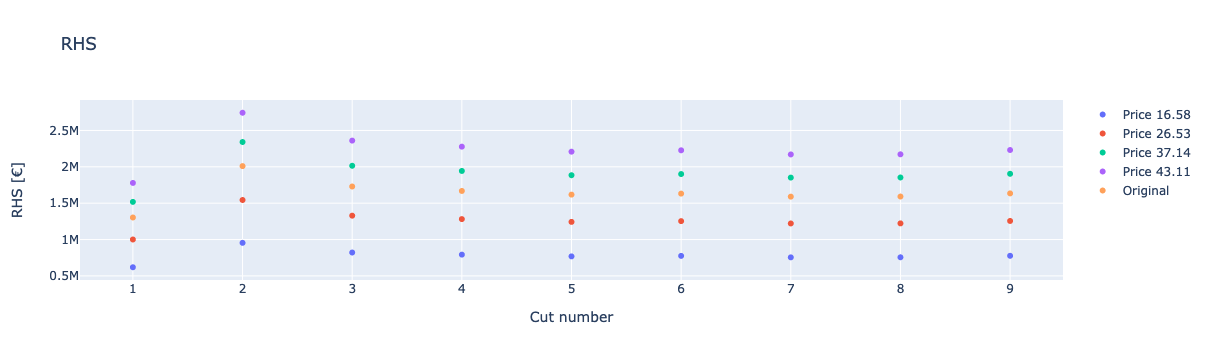

In [10]:
#Plot the scaled and original RHS values

rhs = my_cuts.rhs.get()

fig = go.Figure(layout={'title':f"RHS",'xaxis_title':"Cut number",'yaxis_title':"RHS [€]"})
for r in rhs:
    fig.add_trace(go.Scatter(name=f"Price {r.name:.2f}",x=list(range(1,n_cuts+1)),y=r.values,mode='markers'))    

fig.add_trace(go.Scatter(name=f"Original",x=list(range(1,n_cuts+1)),y=rhs_in,mode='markers'))    
fig.show()

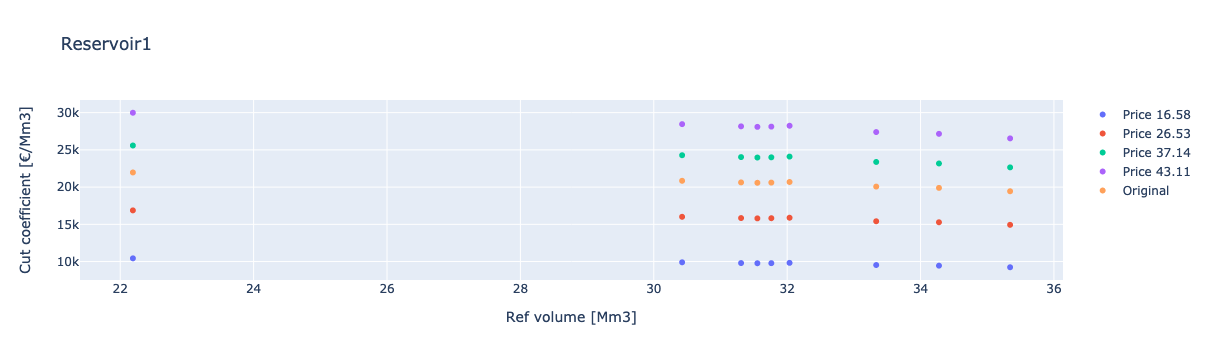

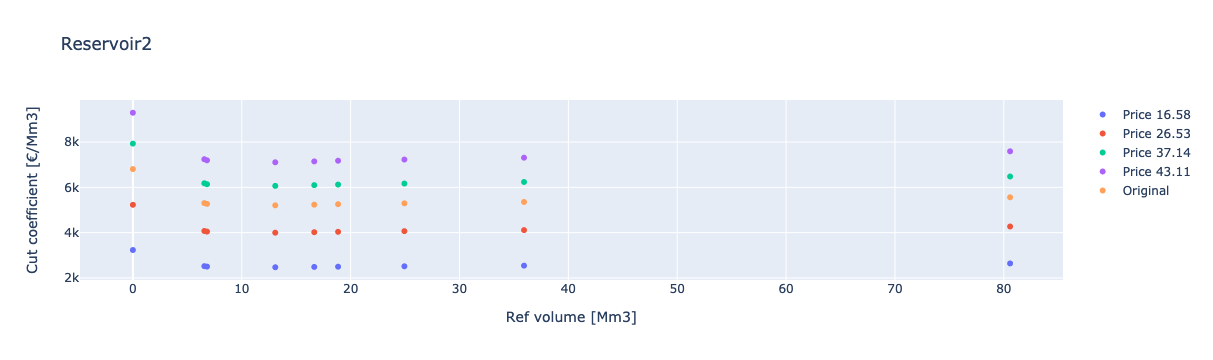

In [11]:
#Plot the scaled and original (ref volume, cut coefficient) pairs
for rsv in shop.model.reservoir:    
    wv_in = rsv.water_value_input.get()
    name = rsv.get_name()
    
    fig = go.Figure(layout={'title':f"{name}",'xaxis_title':"Ref volume [Mm3]",'yaxis_title':r"Cut coefficient [€/Mm3]"})
    for wv in wv_in:
        fig.add_trace(go.Scatter(name=f"Price {wv.name:.2f}",x=wv.index,y=wv.values,text=[f"Cut number {i+1}" for i in range(n_cuts)],mode='markers'))    
    
    fig.add_trace(go.Scatter(name=f"Original",x=cut_coeffs[name][0],y=cut_coeffs[name][1],text=[f"Cut number {i+1}" for i in range(n_cuts)],mode='markers'))    
    
    fig.show()


Now we run the model and take a look at the final cut value and the binding cuts:

In [12]:
#Optimize model by calling "run_model"
run_model(shop)

#Get the final end value of the cut group, which is the future expected (negative) profit
cut_val = -my_cuts.end_value.get()[-1]
print(f"The future expeced income is {cut_val:.2f} €\n")

#Get the binding cut constraints in the two price levels and print the cut information
cut_index_up = my_cuts.binding_cut_up.get()[-1]
cut_index_up = int(cut_index_up)

cut_index_down = my_cuts.binding_cut_down.get()[-1]
cut_index_down = int(cut_index_down)

rhs_out = my_cuts.rhs.get()
active_rhs_up = rhs_out[2].values[cut_index_up]
active_rhs_down = rhs_out[1].values[cut_index_down]

print(f"The binding cut in the set of cuts over the SHOP price is number {cut_index_up+1} out of {n_cuts} with the following values:")
print(f"\tRHS is {active_rhs_up:.2f} €")
for rsv in shop.model.reservoir:
    name = rsv.get_name()
    
    cut_coeffs = rsv.water_value_input.get()[2]
    v_ref = cut_coeffs.index[cut_index_up]
    wv = cut_coeffs.values[cut_index_up]

    end_vol = rsv.storage.get()[-1]

    print(f"\tCut coefficient {wv:.2f} €/Mm3 and refernve volume {v_ref:.2f} Mm3 for {name} with end volume {end_vol:.2f} Mm3")
print("")

print(f"The binding cut in the set of cuts below the SHOP price is number {cut_index_down+1} out of {n_cuts} with the following values:")
print(f"\tRHS is {active_rhs_down:.2f} €")
for rsv in shop.model.reservoir:
    name = rsv.get_name()
    
    cut_coeffs = rsv.water_value_input.get()[1]
    v_ref = cut_coeffs.index[cut_index_down]
    wv = cut_coeffs.values[cut_index_down]

    end_vol = rsv.storage.get()[-1]

    print(f"\tCut coefficient {wv:.2f} €/Mm3 and refernve volume {v_ref:.2f} Mm3 for {name} with end volume {end_vol:.2f} Mm3")


The future expeced income is 1765891.68 €

The binding cut in the set of cuts over the SHOP price is number 8 out of 9 with the following values:
	RHS is 1853581.92 €
	Cut coefficient 23376.95 €/Mm3 and refernve volume 33.33 Mm3 for Reservoir1 with end volume 32.64 Mm3
	Cut coefficient 6139.45 €/Mm3 and refernve volume 6.81 Mm3 for Reservoir2 with end volume 37.29 Mm3

The binding cut in the set of cuts below the SHOP price is number 8 out of 9 with the following values:
	RHS is 1222141.93 €
	Cut coefficient 15413.37 €/Mm3 and refernve volume 33.33 Mm3 for Reservoir1 with end volume 32.64 Mm3
	Cut coefficient 4047.99 €/Mm3 and refernve volume 6.81 Mm3 for Reservoir2 with end volume 37.29 Mm3


The final value of the global water value result time series is equal to the weighted sum of the binding cut coefficients in the price levels above and below the average SHOP price. The interpolation weights used in SHOP are:

In [13]:
w_up = (average_price - prices[1])/(prices[2]-prices[1])
w_down = 1 - w_up
print(f"Weight for cuts with price {(prices[1]):.2f}: {w_down:.3f}")
print(f"Weight for cuts with price {(prices[2]):.2f}: {w_up:.3f}")

Weight for cuts with price 26.53: 0.375
Weight for cuts with price 37.14: 0.625


In [14]:
pd.DataFrame([rsv.storage.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir storage")
pd.DataFrame([-rsv.water_value_global_result.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir global water value")

## cuts.py <a name="cuts.py"></a>

In [15]:
%pycat cuts.py

import pandas as pd
import numpy as np

def build_model(shop):
    starttime = pd.Timestamp('2018-01-23 00:00:00')
    endtime = pd.Timestamp('2018-01-26')
    shop.set_time_resolution(starttime=starttime, endtime=endtime, timeunit="hour", timeresolution=pd.Series(index=[starttime],data=[1]))
    
    rsv1 = shop.model.reservoir.add_object('Reservoir1')
    rsv1.max_vol.set(39)
    rsv1.lrl.set(860)
    rsv1.hrl.set(905)
    rsv1.vol_head.set(pd.Series([860, 906, 907], index=[0, 39, 41.66], name=0))    

    rsv2 = shop.model.reservoir.add_object('Reservoir2')
    rsv2.max_vol.set(97.5)   
    rsv2.lrl.set(650)   
    rsv2.hrl.set(679)    
    rsv2.vol_head.set(pd.Series([650, 679, 680], index=[0, 97.5, 104.15], name=0))
    
    plant1 = shop.model.plant.add_object('Plant1')
    plant1.outlet_line.set(672)
    plant1.main_loss.set([0])
    plant1.penstock_loss.set([0.001])
    plant1.mip_flag.set(1)
    for gen_no in range(2):
        gen=shop.model.generator.add_object(f"{plant1.get_

## rhs_file.txt <a name="rhs_file.txt"></a>

In [16]:
%pycat rhs_file.txt

1302893.6182906777,
2010020.6584548976,
1729395.5394430447,
1668317.685566983,
1617873.4676792584,
1631679.5873724935,
1589941.6988939482,
1591330.6347999508,
1634520.697565704,


## wv_file.txt <a name="wv_file.txt"></a>

In [17]:
%pycat wv_file.txt

Reservoir1,
22.189997229001772,21968.07763058306,
32.03581986796384,20688.954513778233,
31.76238232934574,20603.711537308358,
34.27612278140506,19894.176616677698,
31.308703005587205,20630.492878183457,
35.342460717556115,19445.091174171313,
31.55324433296073,20578.981049356116,
33.33476051403972,20069.49405857465,
30.424671002337547,20846.24763536947,
Reservoir2,
0.0,6809.24813956154,
80.5757764809413,5562.450020645937,
35.92729985954057,5355.954542531482,
16.659022633000312,5235.792909168047,
18.847154805742804,5257.2399850450465,
6.5591822497789565,5306.294672951913,
13.076925078859233,5207.172964047769,
6.809364705774897,5270.822824122645,
24.938676360224974,5295.6223609056615,


## model.yaml <a name="model.yaml"></a>

In [18]:
%pycat model.yaml

time:
  starttime: 2018-01-23 00:00:00
  endtime: 2018-01-26 00:00:00
  timeunit: hour
  timeresolution:
    2018-01-23 00:00:00: 1
model:
  reservoir:
    Reservoir1:
      start_head: 900
      max_vol: 39
      lrl: 860
      hrl: 905
      vol_head:
        ref: 0
        x:
          - 0
          - 39
          - 41.66
        y:
          - 860
          - 906
          - 907
      inflow:
        2018-01-23 00:00:00: 80
    Reservoir2:
      start_head: 670
      max_vol: 97.5
      lrl: 650
      hrl: 679
      vol_head:
        ref: 0
        x:
          - 0
          - 97.5
          - 104.15
        y:
          - 650
          - 679
          - 680
      inflow:
        2018-01-23 00:00:00: 60
  plant:
    Plant1:
      equal_distribution: -1
      outlet_line: 672
      main_loss:
        - 0
      penstock_loss:
        - 0.001
      mip_flag:
        2018-01-23 00:00:00: 1
    Plant2:
      equal_distribution: -1
      outlet_line: 586
      main_loss:
        - 0
    

## standard_cuts.yaml <a name="standard_cuts.yaml"></a>

In [19]:
%pycat standard_cuts.yaml

model:
  reservoir:
    Reservoir1:      
      water_value_input:
        - ref: 0
          x:
            - 22.189997229002
            - 32.035819867964
            - 31.762382329346
            - 34.276122781405
            - 31.308703005587
            - 35.342460717556
            - 31.553244332961
            - 33.33476051404
            - 30.424671002338
          y:
            - 21968.077630583
            - 20688.954513778
            - 20603.711537308
            - 19894.176616678
            - 20630.492878183
            - 19445.091174171
            - 20578.981049356
            - 20069.494058575
            - 20846.247635369
    Reservoir2:
      water_value_input:
        - ref: 0
          x:
            - 0
            - 80.575776480941
            - 35.927299859541
            - 16.659022633
            - 18.847154805743
            - 6.559182249779
            - 13.076925078859
            - 6.8093647057749
            - 24.938676360225
          y:
            - 6

## price_dep_cuts.yaml <a name="price_dep_cuts.yaml"></a>

In [20]:
%pycat price_dep_cuts.yaml

model:
  reservoir:
    Reservoir1:      
      water_value_input:
        - ref: 16.581902777777778
          x:
            - 22.189997229002
            - 32.035819867964
            - 31.762382329346
            - 34.276122781405
            - 31.308703005587
            - 35.342460717556
            - 31.553244332961
            - 33.33476051404
            - 30.424671002338
          y:
            - 10434.836874527
            - 9827.2533940447
            - 9786.7629802215
            - 9449.7338929219
            - 9799.4841171371
            - 9236.4183077314
            - 9775.0159984442
            - 9533.009677823
            - 9901.9676268005
        - ref: 26.531044444444447
          x:
            - 22.189997229002
            - 32.035819867964
            - 31.762382329346
            - 34.276122781405
            - 31.308703005587
            - 35.342460717556
            - 31.553244332961
            - 33.33476051404
            - 30.424671002338
          y:
      

## model.ascii <a name="model.ascii"></a>

In [21]:
%pycat model.ascii

#;
# Name of the datafile is: standard_cuts.ascii;
#;

SIZE
#Num_reservoirs;Num_plants;Num_gates;Num_junctions
2            2          0           0

OPTIMIZATION time
#Start_time;   End_time;
20180123000000 20180126000000

#;N_full_iterations;Accuracy;
OPTIMIZATION   1000       1.00
#Time resolution in the optimization;
#Id;Number;Start_Time;Time_unit;Period;Data_type;Y_unit;Pts;
0      0 20180123000000000 HOUR      0     -1 NO_UNIT     73
#            Time;      f(t);
20180123000000000 1.00000000000000000

RESERVOIR attributes Reservoir1
#ID;Water_course;Type;Maxvol;Lrl;Hrl;
0      0      0     39.000    860.000    905.000

RESERVOIR vol_head Reservoir1
#Id;Number;Reference;Pts;X_unit;Y_unit
0      0       0.00      3 MM3 METER
#  x_value;   y_value;
0.0000000000 860.0000000000
39.0000000000 906.0000000000
41.6600000000 907.0000000000

RESERVOIR inflow Reservoir1
#Id;Number;Start_Time;Time_unit;Period;Data_type;Y_unit;Pts;
0      0 20180123000000000 HOUR      0     -1 M3/S     73
#  

## name_coupling.txt <a name="name_coupling.txt"></a>

In [22]:
%pycat name_coupling.txt

NAMELIST_ICC
2, 1001
3, Reservoir1
2, 1002
3, Reservoir2
-1


## cut_order.txt <a name="cut_order.txt"></a>

In [23]:
%pycat cut_order.txt

CUTORDER
1 1001 0 0
2 1002 0 0


## standard_cuts.txt <a name="standard_cuts.txt"></a>

In [24]:
%pycat standard_cuts.txt

SHOP_WATER_VALUES
9 2
1 1302.8936182906778
2.196807763058306 0.680924813956154
56.89742879231224 0.0
2 2010.0206584548976
2.0688954513778235 0.5562450020645937
82.14312786657395 82.64182203173468
3 1729.3955394430448
2.060371153730836 0.5355954542531483
81.44200597268139 36.84851267645186
4 1668.317685566983
1.98941766166777 0.5235792909168048
87.88749431129501 17.086177059487497
5 1617.8734676792585
2.063049287818346 0.5257239985045047
80.2787256553518 19.330415185377234
6 1631.6795873724934
1.9445091174171314 0.5306294672951913
90.62169414757977 6.727366410029699
7 1589.9416988939483
2.0578981049356115 0.5207172964047769
80.9057546998993 13.412230850112033
8 1591.3306347999508
2.006949405857465 0.5270822824122645
85.47374490779416 6.983963800794766
9 1634.5206975657038
2.084624763536947 0.5295622360905662
78.01197692907063 25.578129600230742
1.0 1.0
1001 1002
-1


## price_dep_cuts.txt <a name="price_dep_cuts.txt"></a>

In [25]:
%pycat price_dep_cuts.txt

SHOP_EXT_WATER_VALUES
1.658190277777778 618.8744686880718 02 1.0434836874526954 56.89742879231224 0.3234392866291731 0.0 00
1.658190277777778 954.7598127660763 02 0.9827253394044662 82.14312786657395 0.26421637598068204 82.64182203173468 00
1.658190277777778 821.4628812354462 02 0.978676298022147 81.44200597268139 0.25440784077024536 36.84851267645186 00
1.658190277777778 792.4509006443169 02 0.9449733892921907 87.88749431129501 0.24870016318548224 17.086177059487497 00
1.658190277777778 768.4898971476478 02 0.9799484117137142 80.2787256553518 0.2497188992896397 19.330415185377234 00
1.658190277777778 775.0478040019344 02 0.9236418307731374 90.62169414757977 0.2520489969652159 6.727366410029699 00
1.658190277777778 755.2223069746253 02 0.9775015998444154 80.9057546998993 0.24734071579226904 13.412230850112033 00
1.658190277777778 755.8820515299766 02 0.953300967782296 85.47374490779416 0.25036408414582567 6.983963800794766 00
1.658190277777778 776.3973313437093 02 0.9901967626800497 78